In [1]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import seaborn as sb
import time
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

# modules from particles
import particles  # core module
from particles import smc_samplers as ssp
from particles import distributions as dists  # where probability distributions are defined
from particles import resampling as rs
from particles import state_space_models as ssm  # where state-space models are defined

import md_lvm
importlib.reload(md_lvm)

<module 'md_lvm' from '/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py'>

In [123]:
mu = -1.3
rho = 0.5
sigma = 0.18

In [124]:
T = 100
x = np.zeros(T)
y = np.zeros(T)

x[0] = np.random.normal(loc = mu, scale = sigma / np.sqrt(1. - rho**2))
y[0] = np.random.normal(loc=0., scale=np.sqrt(np.exp(x[0])))
for t in range(1, T):
    x[t] = np.random.normal(loc = mu + rho*(x[t-1]-mu), scale = sigma)
    y[t] = np.random.normal(loc=0., scale=np.sqrt(np.exp(x[t])))

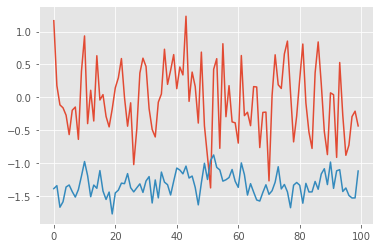

In [125]:
plt.plot(y)
plt.plot(x)

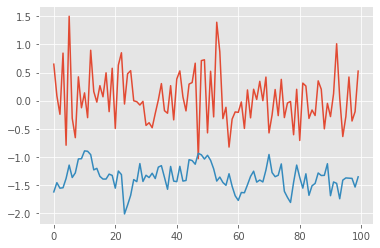

In [135]:
class StochVol(ssm.StateSpaceModel):
    sigma = sigma
    mu = mu
    def PX0(self):  # Distribution of X_0
        return dists.Normal(loc=self.mu, scale=self.sigma / np.sqrt(1. - self.rho**2))
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        return dists.Normal(loc=self.mu + self.rho * (xp - self.mu), scale=self.sigma)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        return dists.Normal(loc=0., scale=np.sqrt(np.exp(x)))

my_model = StochVol(mu=mu, rho=rho, sigma=sigma)  # actual model
true_states, data = my_model.simulate(100)  # we simulate from the model 100 data points

plt.style.use('ggplot')
plt.figure()
plt.plot(data)
plt.plot(true_states)

In [136]:
prior_dict = {'rho':dists.Beta(9., 1.)}
my_prior = dists.StructDist(prior_dict)

In [137]:
%%capture
from particles import mcmc  # where the MCMC algorithms (PMMH, Particle Gibbs, etc) live
pmmh = mcmc.PMMH(ssm_cls=StochVol, prior=my_prior, data=data, Nx=50, niter = 1000)
pmmh.run()  # Warning: takes a few seconds

/Users/francescacrucinio/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


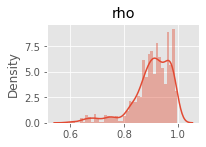

In [138]:
# plot the marginals
burnin = 100  # discard the 100 first iterations
for i, param in enumerate(prior_dict.keys()):
    plt.subplot(2, 2, i+1)
    sb.distplot(pmmh.chain.theta[param][burnin:], 40)
    plt.title(param)

## PGD and IPLA

In [108]:
def pgd(y, h, K, N, th0, X):
    """Particle Gradient Ascent Algorithm. Returns parameter estimates."""
    D = y.size  # Extract dimension of latent variables.
    th = np.zeros((K, th0.size))
    th[0, 0] = th0
    for k in range(K-1):
        # Update parameter estimate:
        th[k+1] = th[k] + h*ave_grad_th_rho(th[k], X)
        # Update particle cloud:
        X = (X + h*grad_x_rho(th[k], X, y)
               + np.sqrt(2*h)*np.random.normal(0, 1, (N, D)))
    return th, X

def ipla(y, h, K, N, th, X):
    """Particle Gradient Ascent Algorithm. Returns parameter estimates."""
    D = y.size  # Extract dimension of latent variables.
    th = np.zeros((K, th0.size))
    th[0, 0] = th0
    for k in range(K-1):
        # Update parameter estimate:
        th[k+1] = th[k] + h*ave_grad_th_rho(th[k], X)+ np.sqrt(2*h/N)*np.random.normal(0, 1, size = 1)
        # Update particle cloud:
        X = (X + h*grad_x_rho(th[k], X, y)
               + np.sqrt(2*h)*np.random.normal(0, 1, (N, D)))
    return th, X

In [79]:
def ave_grad_th(th, x):
    """Returns theta-gradient of log density averaged over particle cloud."""
    grad_rho = -th[0]/(1-th[0]**2)+th[0]*np.mean((x[:, 0]-th[1])**2)/sigma**2 + np.mean(np.sum((x[:,:(T-1)]-th[1]) * (x[:,1:]-th[1]-th[0]*(x[:,:(T-1)]-th[1])), axis = 1)/sigma**2)
    grad_mu = (1-th[0]**2)*np.mean(x[:, 0]-th[1])/sigma**2 + np.mean(np.sum((1-th[0])*(x[:,1:]-th[1]-th[0]*(x[:,:(T-1)]-th[1])), axis = 1)/sigma**2)
    return np.array([grad_rho, grad_mu])

def ave_grad_th_rho(th, x):
    """Returns theta-gradient of log density averaged over particle cloud."""
    grad_rho = -th/(1-th**2)+th*np.mean((x[:, 0]-mu)**2)/sigma**2 + np.mean(np.sum((x[:,:(T-1)]-mu) * (x[:,1:]-mu-th*(x[:,:(T-1)]-mu)), axis = 1)/sigma**2)
    return grad_rho

def ave_grad_th_mu(th, x):
    """Returns theta-gradient of log density averaged over particle cloud."""
    grad_mu = (1-rho**2)*np.mean(x[:, 0]-th)/sigma**2 + np.mean(np.sum((1-rho)*(x[:,1:]-th-rho*(x[:,:(T-1)]-th)), axis = 1)/sigma**2)
    return grad_mu

def grad_x(th, x, y):
    """Returns x-gradient of log density vectorized over particles."""
    grad = y**2*np.exp(-x)/2-1/2
    grad[:, 0] = grad[:, 0] + th[0]*(x[:, 1]-th[1]-th[0]*(x[:,0]-th[1]))/sigma**2-(x[:, 0]-th[1])*(1-th[0]**2)/sigma**2
    grad[:, T-1] = grad[:, T-1] - (x[:, T-1]-th[1]-th[0]*(x[:, T-2]-th[1]))/sigma**2
    grad[:, 1:(T-1)] = grad[:, 1:(T-1)] - (x[:, 1:(T-1)]-th[1]-th[0]*(x[:, 0:(T-2)]-th[1]))/sigma**2 + th[0]*(x[:, 2:T]-th[1]-th[0]*(x[:,1:(T-1)]-th[1]))/sigma**2
    return grad

def grad_x_rho(th, x, y):
    """Returns x-gradient of log density vectorized over particles."""
    grad = y**2*np.exp(-x)/2-1/2
    grad[:, 0] = grad[:, 0] + th*(x[:, 1]-mu-th*(x[:,0]-mu))/sigma**2-(x[:, 0]-mu)*(1-th**2)/sigma**2
    grad[:, T-1] = grad[:, T-1] - (x[:, T-1]-mu-th*(x[:, T-2]-mu))/sigma**2
    grad[:, 1:(T-1)] = grad[:, 1:(T-1)] - (x[:, 1:(T-1)]-mu-th*(x[:, 0:(T-2)]-mu))/sigma**2 + th*(x[:, 2:T]-mu-th*(x[:,1:(T-1)]-mu))/sigma**2
    return grad

def grad_x_mu(th, x, y):
    """Returns x-gradient of log density vectorized over particles."""
    grad = y**2*np.exp(-x)/2-1/2
    grad[:, 0] = grad[:, 0] + rho*(x[:, 1]-th-rho*(x[:,0]-th))/sigma**2-(x[:, 0]-th)*(1-rho**2)/sigma**2
    grad[:, T-1] = grad[:, T-1] - (x[:, T-1]-th-rho*(x[:, T-2]-th))/sigma**2
    grad[:, 1:(T-1)] = grad[:, 1:(T-1)] - (x[:, 1:(T-1)]-th-rho*(x[:, 0:(T-2)]-th))/sigma**2 + rho*(x[:, 2:T]-th-rho*(x[:,1:(T-1)]-th))/sigma**2
    return grad

In [132]:
N = 10
K = 20000
gamma = 0.00001

th0 = np.array(0)  # Initial parameter guess.
X0 = np.random.normal(size = (N, T))  # Initial particle cloud.

In [139]:
th_pgd, X_pgd = pgd(y, gamma, K, N, th0, X0)
th_ipla, X_ipla = ipla(y, gamma, K, N, th0, X0)

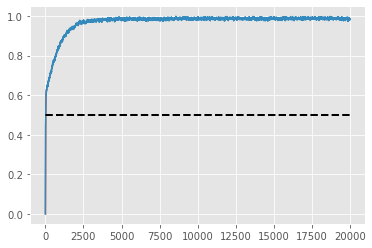

In [140]:
plt.plot(th_pgd)
plt.plot(th_ipla)
plt.plot(rho*np.ones(K), c = 'black', linestyle = 'dashed', lw = 2)